This code is come from [here](https://mlabonne.github.io/blog/posts/2022-04-25-Graph_Isomorphism_Network.html)

# Package Install

In [1]:
import torch
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Visualization
import networkx as nx
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 24})

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 18.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Dataset 특징

- PubMed 데이터베이스에서 당뇨병과 관련된 19,717개의 과학 논문을 포함하고 있다.
- 노드 특징은 500차원의 TF-IDF 가중치 단어 벡터이다.
- TF-IDF 가중치 단어 벡터는 트랜스포머 없이 문서를 요약하는 효율적인 방법이다.
- Task는 세 가지 범주가 있는 다중 클래스 분류이다: 당뇨병 실험 연구, 제1형 당뇨병, 제2형 당뇨병.

In [2]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='.', name="Pubmed")
data = dataset[0]

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Training nodes: {sum(data.train_mask).item()}')
print(f'Evaluation nodes: {sum(data.val_mask).item()}')
print(f'Test nodes: {sum(data.test_mask).item()}')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Processing...
Done!


Dataset: Pubmed()
-------------------
Number of graphs: 1
Number of nodes: 19717
Number of features: 500
Number of classes: 3

Graph:
------
Training nodes: 60
Evaluation nodes: 500
Test nodes: 1000
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


# Model

/usr/local/lib/python3.10/dist-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


Subgraph 0: Data(x=[387, 500], edge_index=[2, 446], y=[387], train_mask=[387], val_mask=[387], test_mask=[387], n_id=[387], e_id=[446], input_id=[16], batch_size=16)
Subgraph 1: Data(x=[256, 500], edge_index=[2, 295], y=[256], train_mask=[256], val_mask=[256], test_mask=[256], n_id=[256], e_id=[295], input_id=[16], batch_size=16)
Subgraph 2: Data(x=[295, 500], edge_index=[2, 339], y=[295], train_mask=[295], val_mask=[295], test_mask=[295], n_id=[295], e_id=[339], input_id=[16], batch_size=16)
Subgraph 3: Data(x=[197, 500], edge_index=[2, 229], y=[197], train_mask=[197], val_mask=[197], test_mask=[197], n_id=[197], e_id=[229], input_id=[12], batch_size=12)


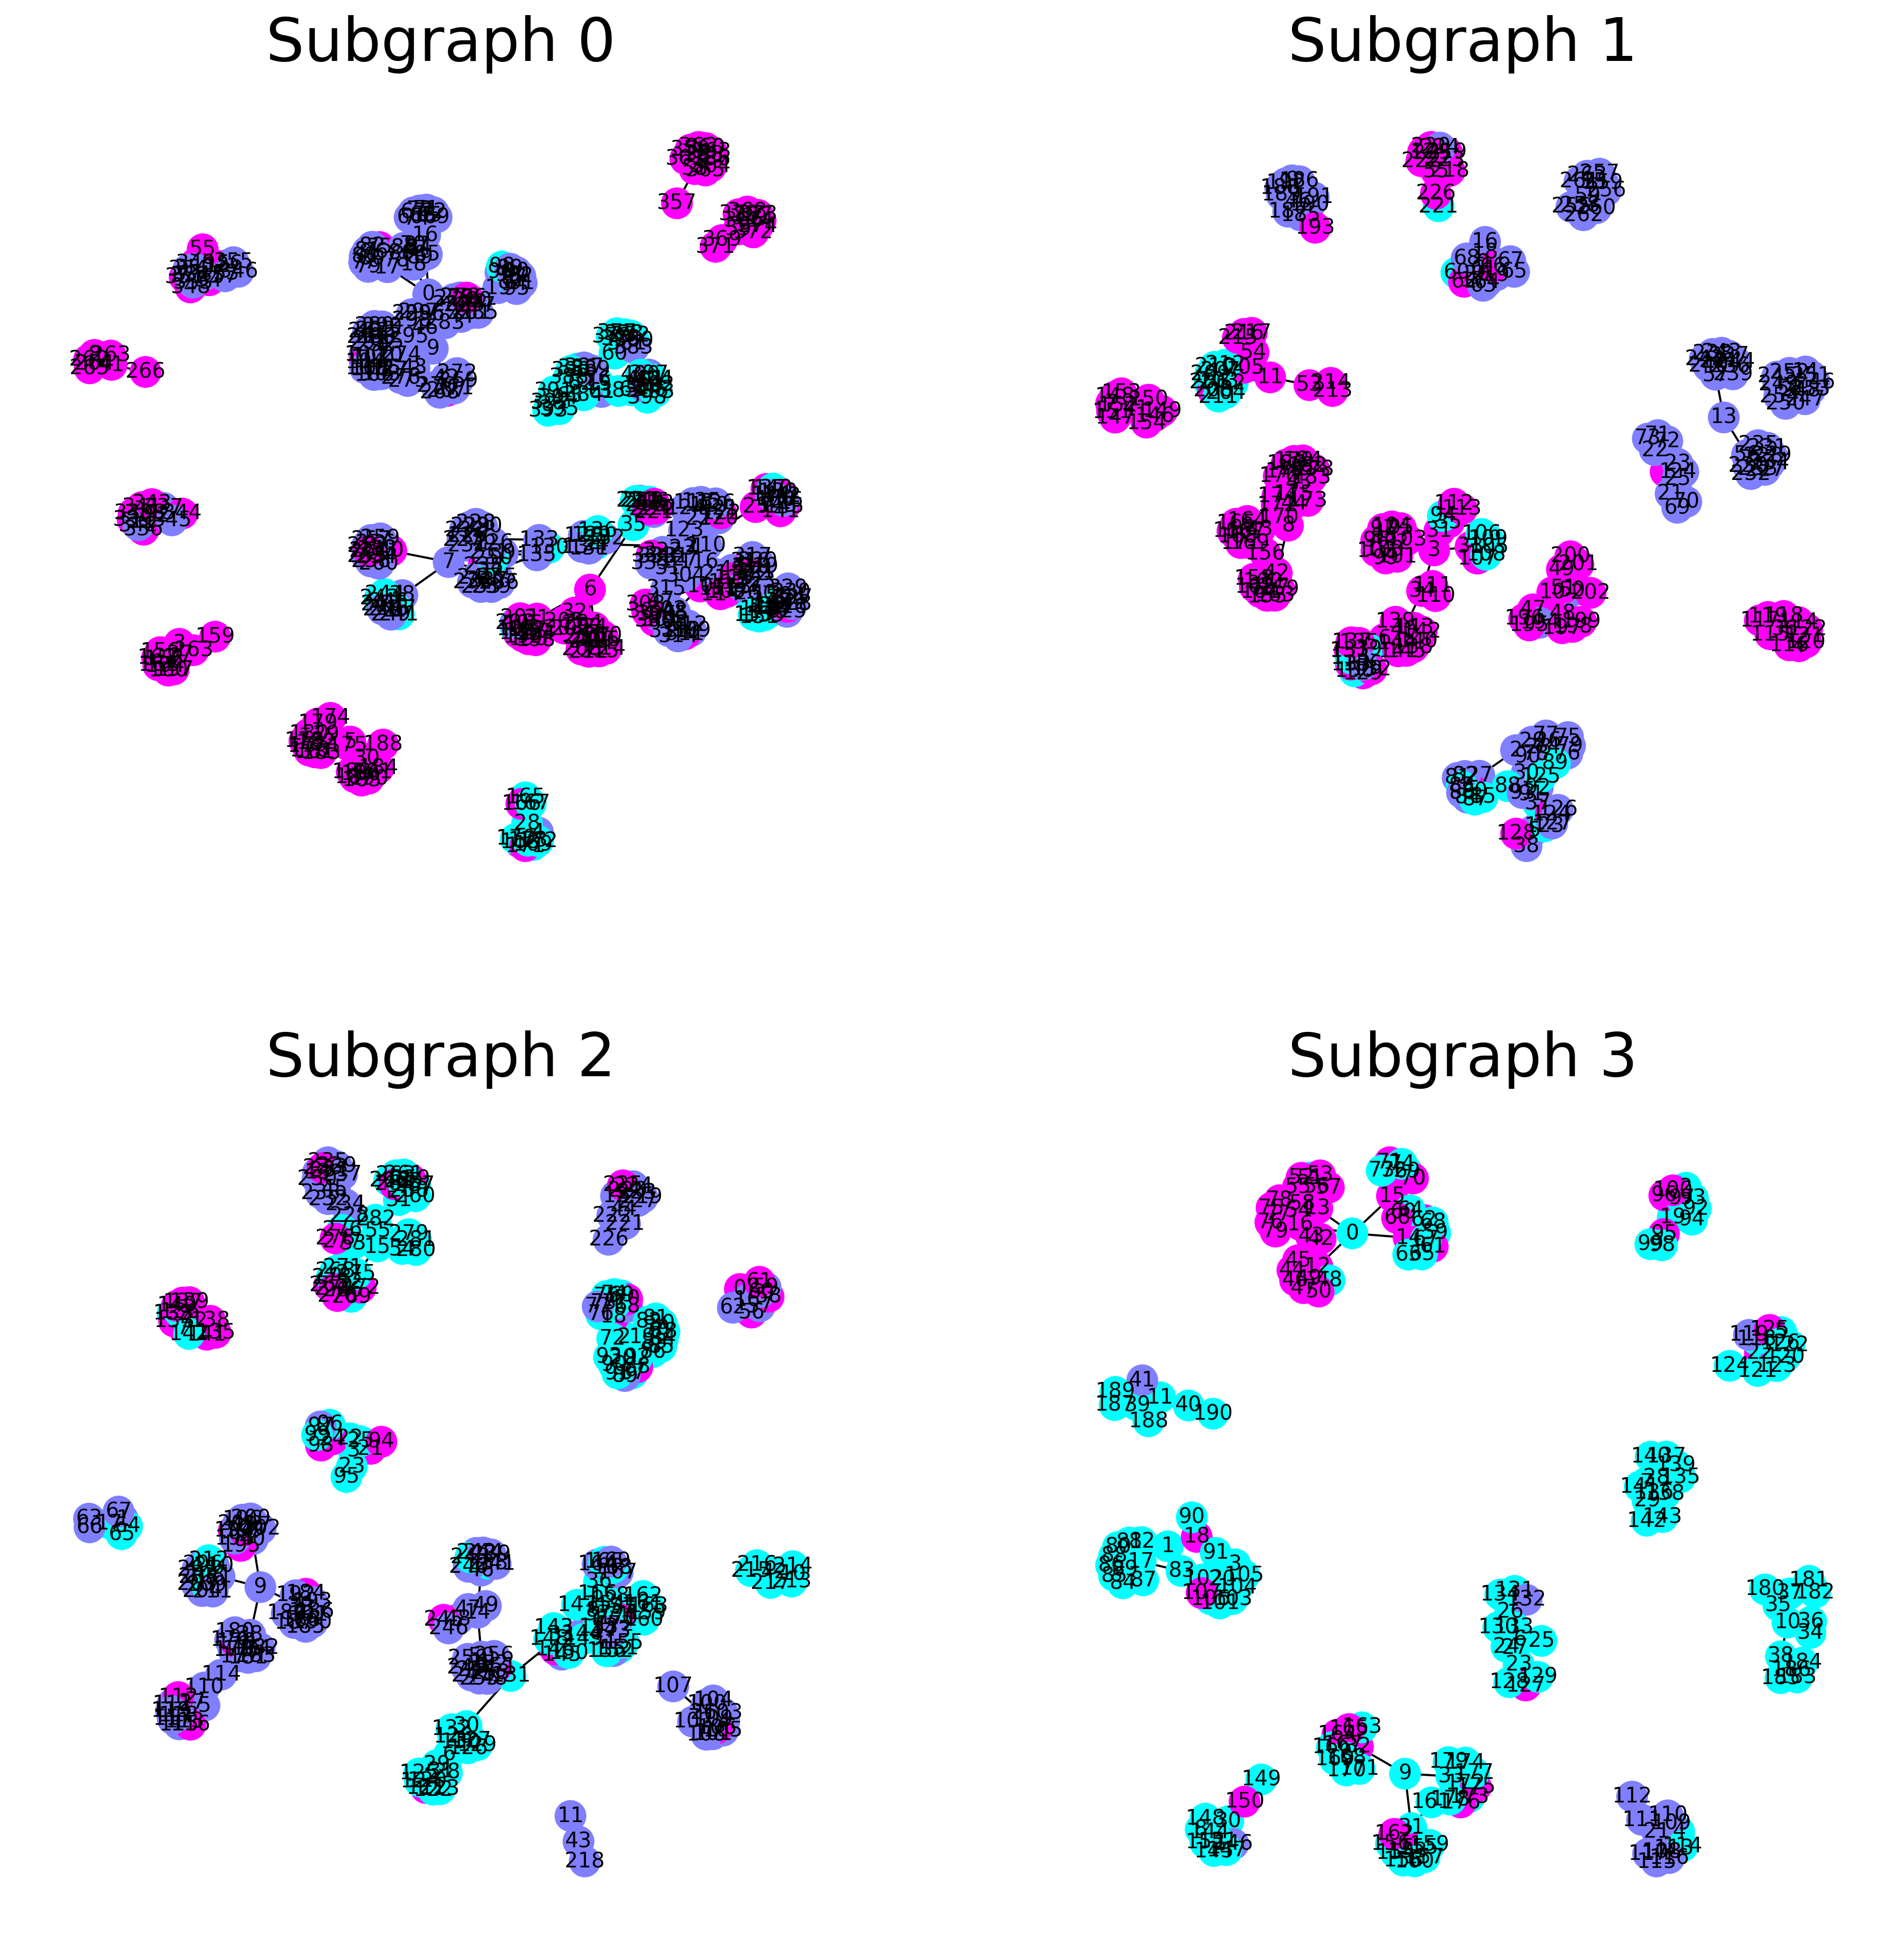

In [3]:
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import to_networkx

# Create batches with neighbor sampling
train_loader = NeighborLoader(
    data,
    num_neighbors=[5, 10],
    batch_size=16,
    input_nodes=data.train_mask,
)

# Print each subgraph
for i, subgraph in enumerate(train_loader):
    print(f'Subgraph {i}: {subgraph}')

# Plot each subgraph
fig = plt.figure(figsize=(16,16))
for idx, (subdata, pos) in enumerate(zip(train_loader, [221, 222, 223, 224])):
    G = to_networkx(subdata, to_undirected=True)
    ax = fig.add_subplot(pos)
    ax.set_title(f'Subgraph {idx}')
    plt.axis('off')
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=True,
                    node_size=200,
                    node_color=subdata.y,
                    cmap="cool",
                    font_size=10
                    )
plt.show()

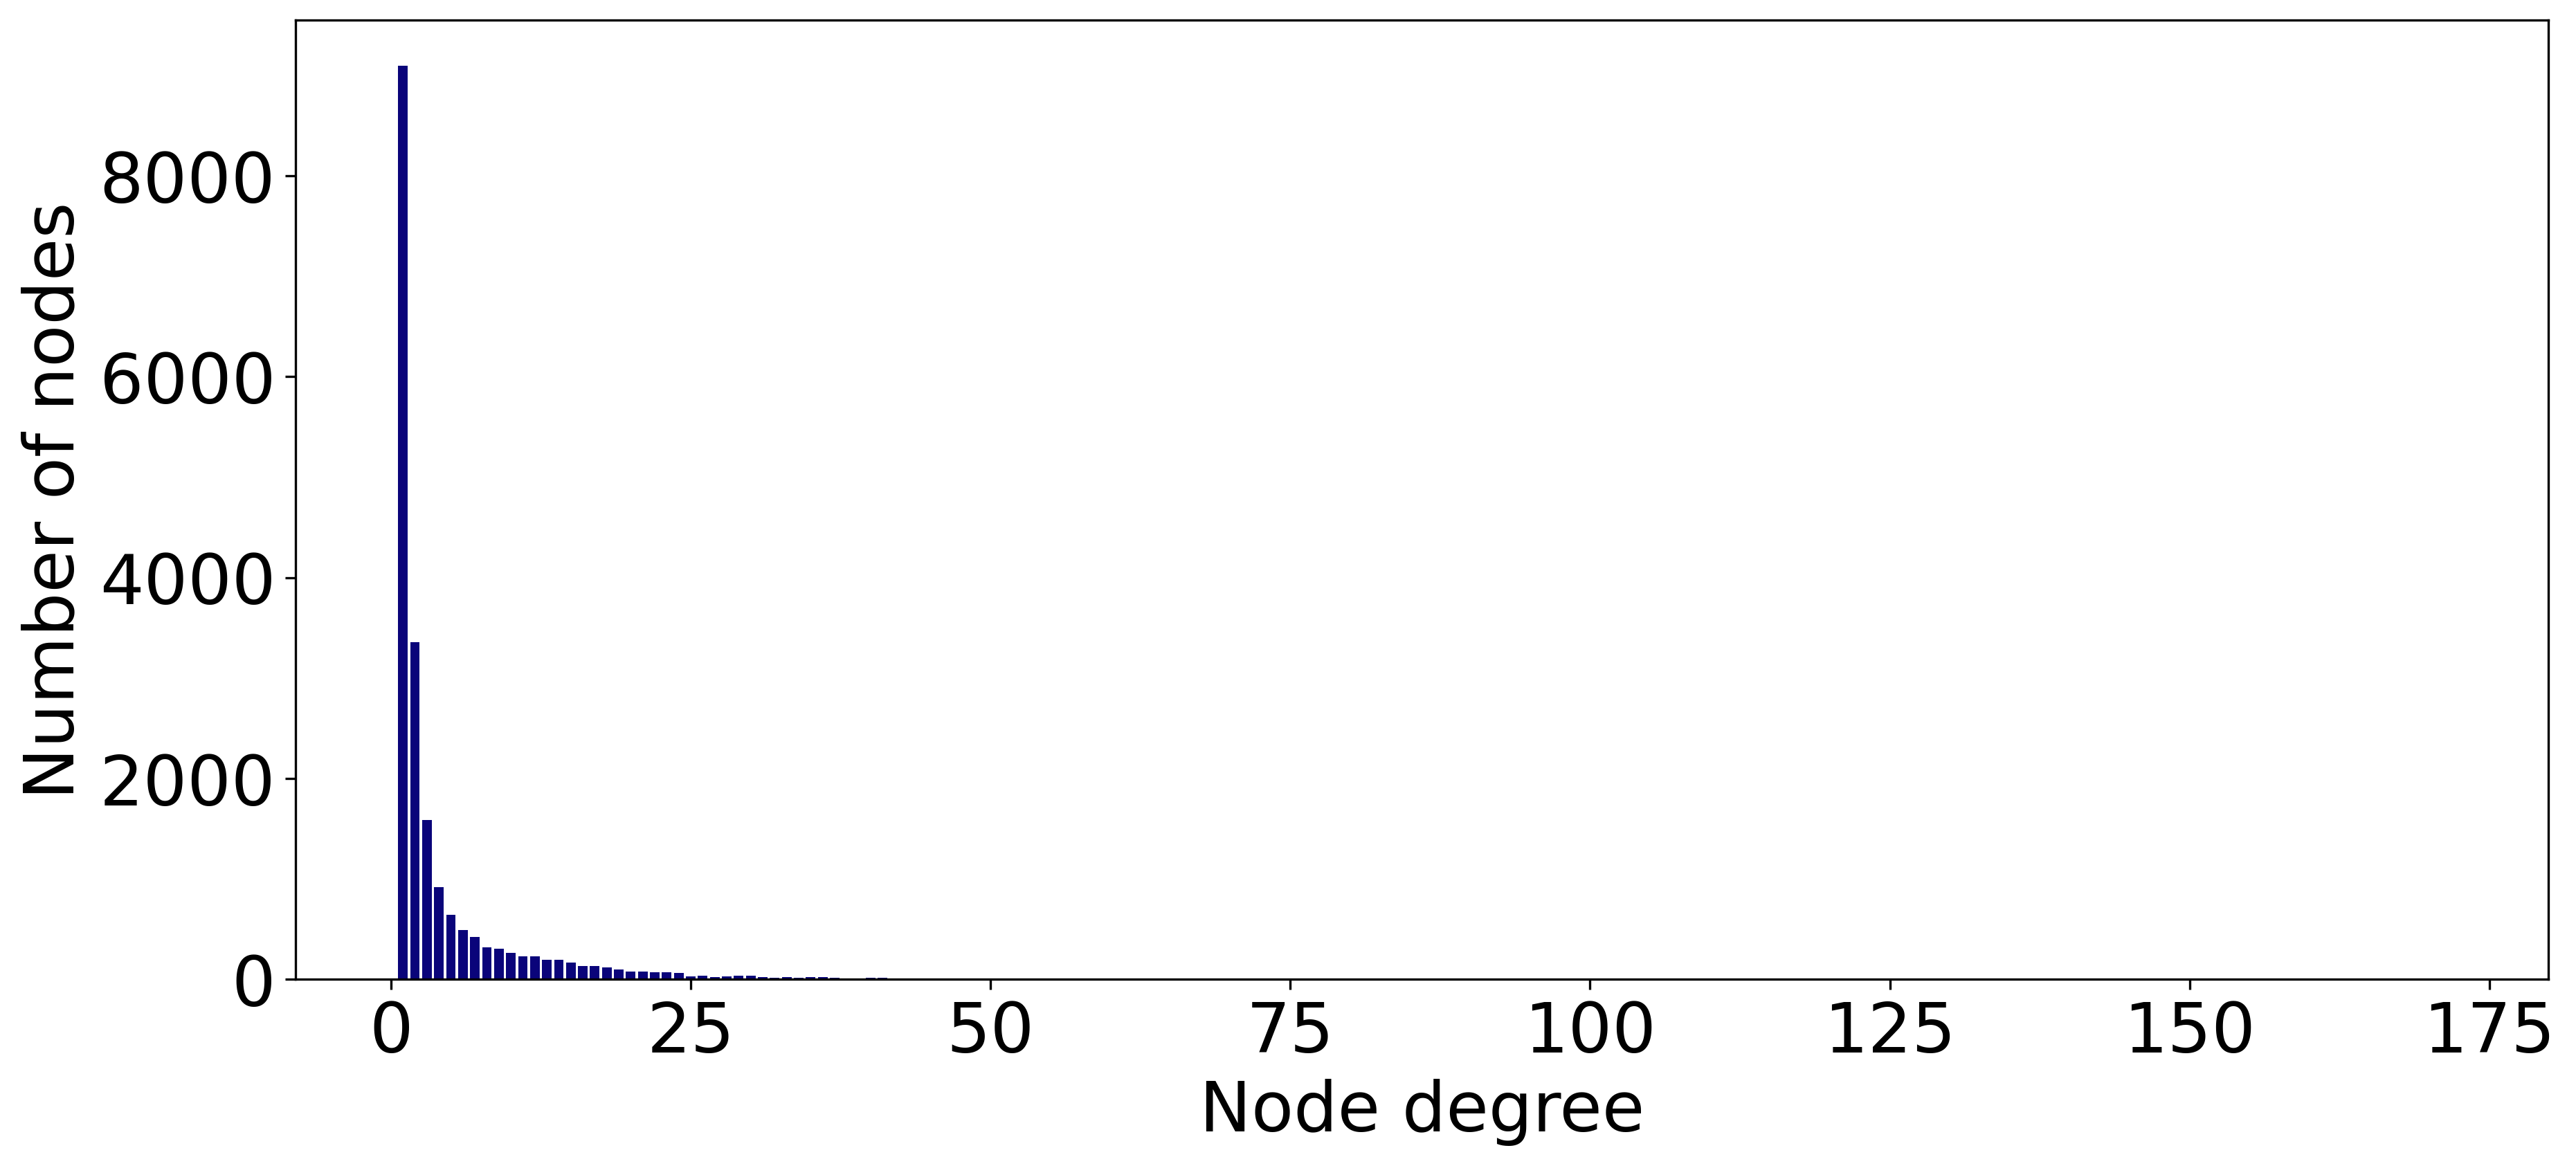

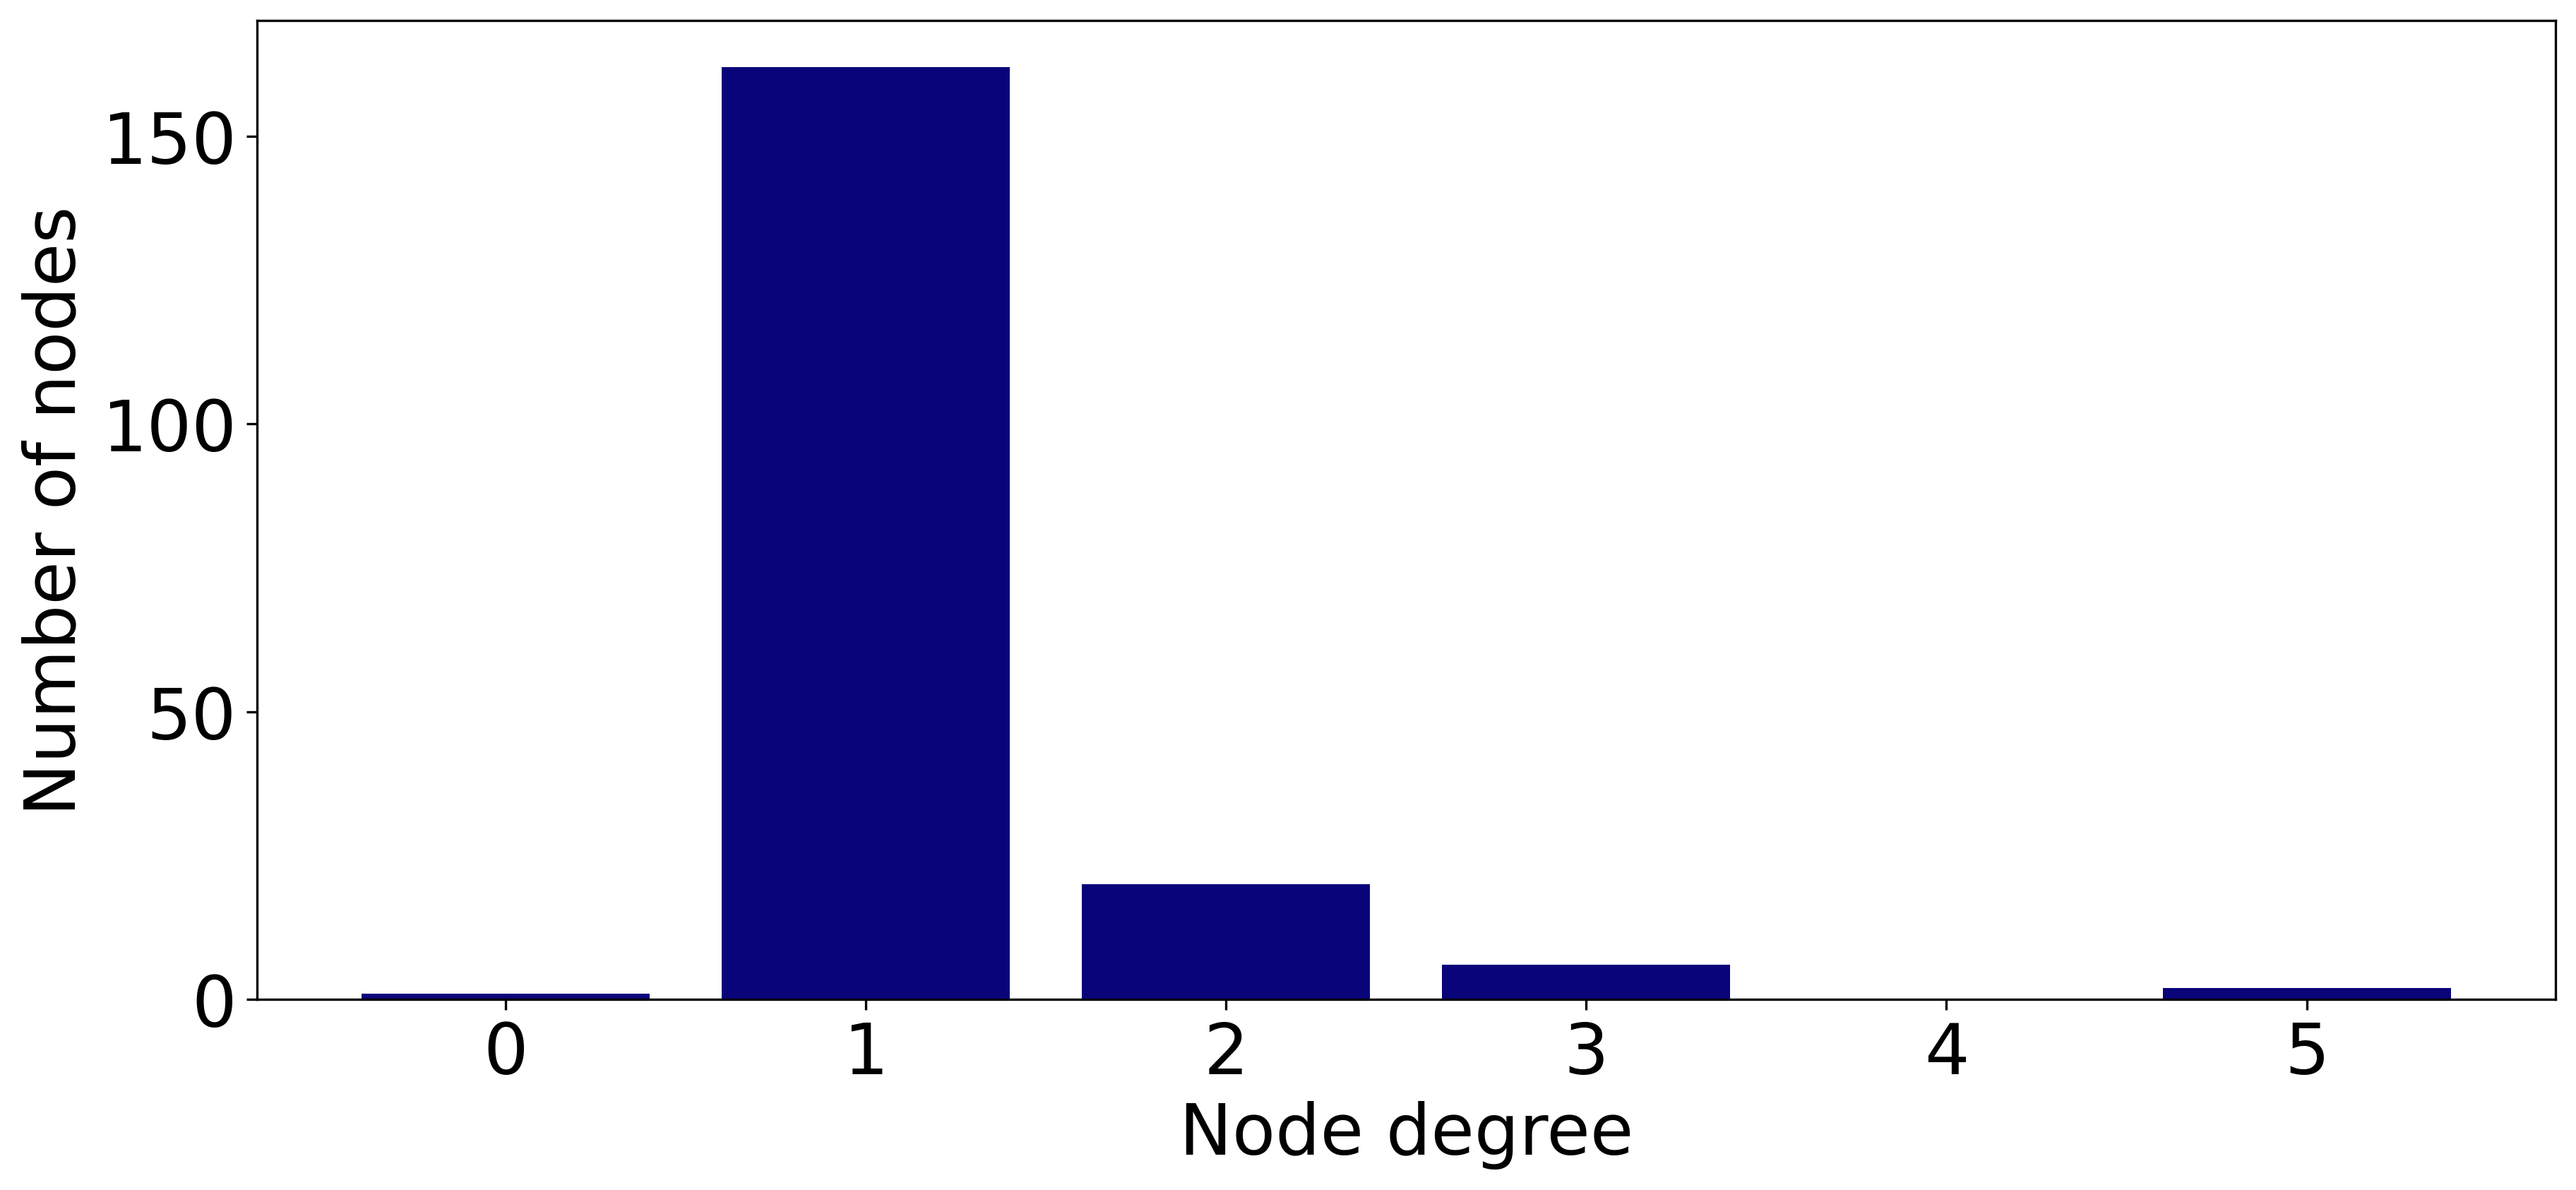

In [4]:
from torch_geometric.utils import degree
from collections import Counter

def plot_degree(data):
    # Get list of degrees for each node
    degrees = degree(data.edge_index[0]).numpy()

    # Count the number of nodes for each degree
    numbers = Counter(degrees)

    # Bar plot
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.set_xlabel('Node degree')
    ax.set_ylabel('Number of nodes')
    plt.bar(numbers.keys(),
            numbers.values(),
            color='#0A047A')

# Plot node degrees from the original graph
plot_degree(data)

# Plot node degrees from the last subgraph
plot_degree(subdata)

In [5]:
import torch
from torch.nn import Linear, Dropout
from torch_geometric.nn import SAGEConv, GATv2Conv, GCNConv
import torch.nn.functional as F


class GraphSAGE(torch.nn.Module):
  """GraphSAGE"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.sage1 = SAGEConv(dim_in, dim_h)
    self.sage2 = SAGEConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = self.sage1(x, edge_index).relu()
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.sage2(h, edge_index)
    return F.log_softmax(h, dim=1)

  def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = self.optimizer

    self.train()
    for epoch in range(epochs+1):
      total_loss = 0
      acc = 0
      val_loss = 0
      val_acc = 0

      # Train on batches
      for batch in train_loader:
        optimizer.zero_grad()
        out = self(batch.x, batch.edge_index)
        loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
        total_loss += loss
        acc += accuracy(out[batch.train_mask].argmax(dim=1),
                        batch.y[batch.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
        val_acc += accuracy(out[batch.val_mask].argmax(dim=1),
                            batch.y[batch.val_mask])

      # Print metrics every 10 epochs
      if(epoch % 10 == 0):
          print(f'Epoch {epoch:>3} | Train Loss: {total_loss/len(train_loader):.3f} '
                f'| Train Acc: {acc/len(train_loader)*100:>6.2f}% | Val Loss: '
                f'{val_loss/len(train_loader):.2f} | Val Acc: '
                f'{val_acc/len(train_loader)*100:.2f}%')

class GAT(torch.nn.Module):
  """Graph Attention Network"""
  def __init__(self, dim_in, dim_h, dim_out, heads=8):
    super().__init__()
    self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
    self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=heads)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.005,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.6, training=self.training)
    h = self.gat1(x, edge_index)
    h = F.elu(h)
    h = F.dropout(h, p=0.6, training=self.training)
    h = self.gat2(h, edge_index)
    return F.log_softmax(h, dim=1)

  def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = self.optimizer

    self.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        out = self(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1),
                       data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                           data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                  f' {acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

class GCN(torch.nn.Module):
  """Graph Convolutional Network"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.gcn1 = GCNConv(dim_in, dim_h)
    self.gcn2 = GCNConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.5, training=self.training)
    h = self.gcn1(h, edge_index).relu()
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.gcn2(h, edge_index)
    return F.log_softmax(h, dim=1)

  def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = self.optimizer

    self.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        out = self(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1),
                       data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                           data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                  f' {acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

@torch.no_grad()
def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

In [6]:
%%time

# Create GraphSAGE
graphsage = GraphSAGE(dataset.num_features, 64, dataset.num_classes)
print(graphsage)

# Train
graphsage.fit(data, 200)

# Test
print(f'\nGraphSAGE test accuracy: {test(graphsage, data)*100:.2f}%\n')

GraphSAGE(
  (sage1): SAGEConv(500, 64, aggr=mean)
  (sage2): SAGEConv(64, 3, aggr=mean)
)
Epoch   0 | Train Loss: 1.126 | Train Acc:  21.42% | Val Loss: 1.12 | Val Acc: 31.25%
Epoch  10 | Train Loss: 0.113 | Train Acc: 100.00% | Val Loss: 0.74 | Val Acc: 75.56%
Epoch  20 | Train Loss: 0.052 | Train Acc: 100.00% | Val Loss: 0.61 | Val Acc: 72.92%
Epoch  30 | Train Loss: 0.026 | Train Acc: 100.00% | Val Loss: 0.45 | Val Acc: 89.29%
Epoch  40 | Train Loss: 0.021 | Train Acc: 100.00% | Val Loss: 0.47 | Val Acc: 82.50%
Epoch  50 | Train Loss: 0.016 | Train Acc: 100.00% | Val Loss: 0.62 | Val Acc: 77.53%
Epoch  60 | Train Loss: 0.024 | Train Acc: 100.00% | Val Loss: 0.45 | Val Acc: 84.70%
Epoch  70 | Train Loss: 0.019 | Train Acc: 100.00% | Val Loss: 0.43 | Val Acc: 80.36%
Epoch  80 | Train Loss: 0.025 | Train Acc: 100.00% | Val Loss: 0.54 | Val Acc: 87.30%
Epoch  90 | Train Loss: 0.018 | Train Acc: 100.00% | Val Loss: 0.60 | Val Acc: 75.15%
Epoch 100 | Train Loss: 0.012 | Train Acc: 100.00

In [7]:
%%time

# Create GCN
gcn = GCN(dataset.num_features, 64, dataset.num_classes)
print(gcn)

# Train
gcn.fit(data, 200)

# Test
print(f'\nGCN test accuracy: {test(gcn, data)*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(500, 64)
  (gcn2): GCNConv(64, 3)
)
Epoch   0 | Train Loss: 1.100 | Train Acc:  28.33% | Val Loss: 1.10 | Val Acc: 36.20%
Epoch  10 | Train Loss: 0.758 | Train Acc:  90.00% | Val Loss: 0.89 | Val Acc: 70.40%
Epoch  20 | Train Loss: 0.370 | Train Acc:  96.67% | Val Loss: 0.69 | Val Acc: 74.40%
Epoch  30 | Train Loss: 0.195 | Train Acc:  98.33% | Val Loss: 0.62 | Val Acc: 76.80%
Epoch  40 | Train Loss: 0.135 | Train Acc:  98.33% | Val Loss: 0.59 | Val Acc: 75.40%
Epoch  50 | Train Loss: 0.090 | Train Acc: 100.00% | Val Loss: 0.58 | Val Acc: 77.40%
Epoch  60 | Train Loss: 0.077 | Train Acc: 100.00% | Val Loss: 0.59 | Val Acc: 75.60%
Epoch  70 | Train Loss: 0.075 | Train Acc: 100.00% | Val Loss: 0.61 | Val Acc: 78.40%
Epoch  80 | Train Loss: 0.079 | Train Acc: 100.00% | Val Loss: 0.62 | Val Acc: 76.40%
Epoch  90 | Train Loss: 0.082 | Train Acc: 100.00% | Val Loss: 0.64 | Val Acc: 76.80%
Epoch 100 | Train Loss: 0.072 | Train Acc: 100.00% | Val Loss: 0.64 | Val Acc: 74